In [1]:
import scanpy as sc
import scvi
import anndata as ad
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
#import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pertpy as pt
os.chdir("/data")
sc._settings.ScanpyConfig.n_jobs = 5

In [3]:
adata= sc.read_h5ad("h5ad/batch_corrected.h5ad")

In [4]:
sccoda_model = pt.tl.Sccoda()

In [6]:
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="annot",
    sample_identifier="sample_id",
    covariate_obs=["condition"],
)

In [7]:
sccoda_data

MuData object with n_obs × n_vars = 124647 × 7010
  var:	'n_cells'
  2 modalities
    rna:	124639 x 7000
      obs:	'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'sample_id', 'condition', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', '_scvi_batch', '_scvi_labels', 'leiden', 'annot', 'scCODA_sample_id'
      var:	'n_cells', 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
      uns:	'_scvi_manager_uuid', '_scvi_uuid', 'annot_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_id_colors', 'umap'
      obsm:	'X_scVI', 'X_scVI_MDE', 'X_umap', 'cellbender_embedding'
      layers:	'counts', 'raw'
      obsp:	'connectivities', 'distances'
    coda:	8 x 10
      obs:	'condition', 'sample_id'
      var:	'n_cells'

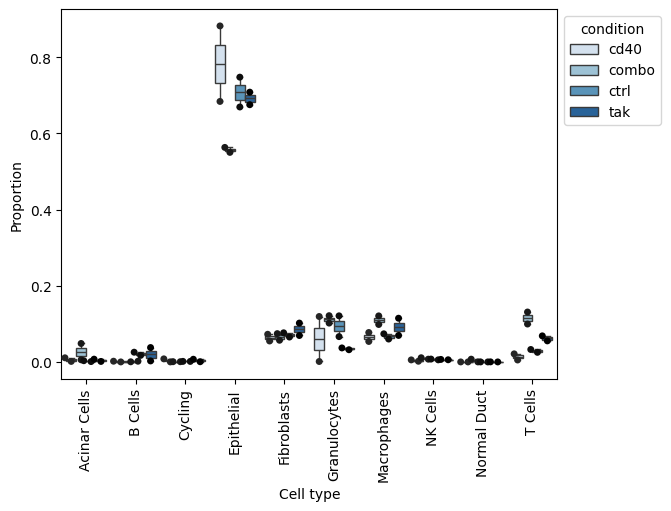

In [16]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda", feature_name="condition", add_dots=True)
plt.show()

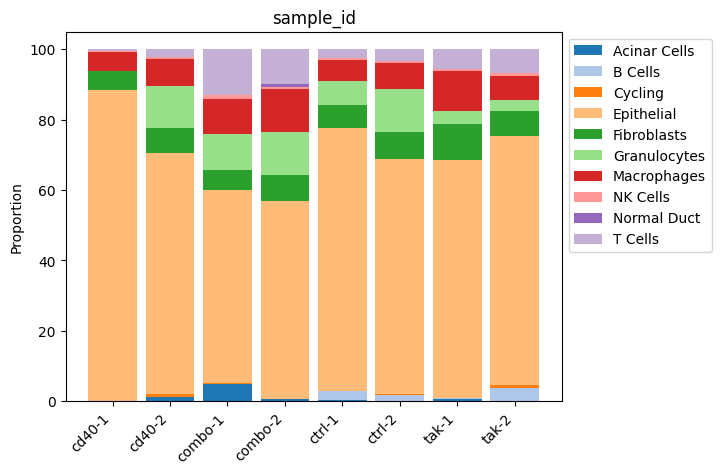

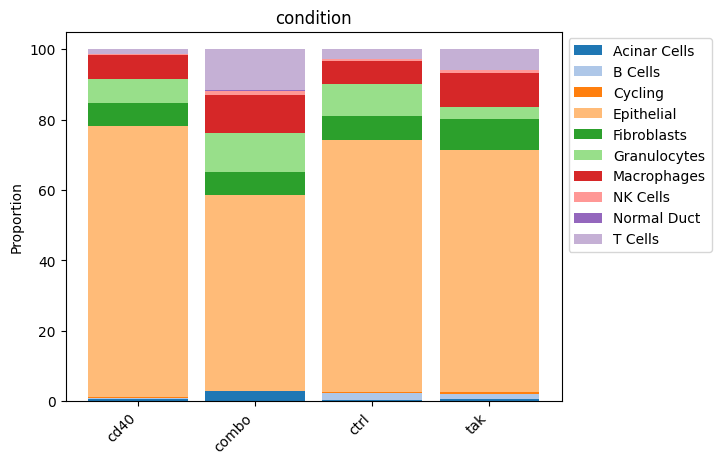

In [18]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="sample_id")
plt.show()

sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda", feature_name="condition")
plt.show()

<Axes: xlabel='Presence', ylabel='Total dispersion'>

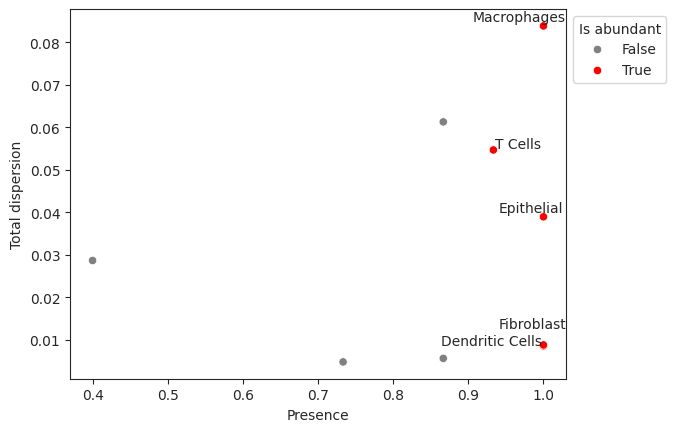

In [8]:
pt.pl.coda.rel_abundance_dispersion_plot(sccoda_data, modality_key="coda", abundant_threshold=0.9)

In [15]:
sccoda_data[sccoda_data.mod["coda"].condition

AnnData object with n_obs × n_vars = 15 × 9
    obs: 'outlier', 'mt_outlier', 'scDblFinder.class', '_scvi_labels', 'condition'
    var: 'n_cells'

In [48]:
comp = ["PTvPT-TX", "GemRvGemR-TX", "PTvGemR", "PTvMRTXR", "GemRvMRTXR"]
res=[]
for n in comp:
    conds = n.split('v')
    dat = sccoda_model.load(
        model.adata[model.adata.obs["condition"].isin(conds)],
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="annot",
        sample_identifier="sample_id",
        covariate_obs=["condition"],
        )
    dat=sccoda_model.prepare(dat, 
                             modality_key="coda", 
                             formula=f"C(condition, Treatment('{conds[0]}'))",
                             reference_cell_type="Epithelial")
    sccoda_model.run_nuts(dat, modality_key="coda", rng_key=2949)
    res.append(dat)
    #sccoda_model.summary(dat, modality_key="coda")

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:22<00:00, 480.80it/s, 127 steps of size 2.40e-02. acc. prob=0.83]


Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:12<00:00, 865.10it/s, 63 steps of size 6.46e-02. acc. prob=0.78] 


Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:20<00:00, 549.36it/s, 127 steps of size 2.88e-02. acc. prob=0.89]


Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:30<00:00, 361.88it/s, 255 steps of size 1.74e-02. acc. prob=0.90]


Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [00:19<00:00, 577.42it/s, 127 steps of size 3.42e-02. acc. prob=0.83]


In [27]:
for n in res:
    print(sccoda_model.credible_effects(n, modality_key="coda"))

Covariate                               Cell Type      
C(condition, Treatment('PT'))[T.PT-TX]  Acinar             False
                                        Dendritic Cells    False
                                        Epithelial         False
                                        Fibroblast         False
                                        Islet              False
                                        Macrophages         True
                                        Mast Cells         False
                                        Monocytes??        False
                                        T Cells             True
Name: Final Parameter, dtype: bool
Covariate                                   Cell Type      
C(condition, Treatment('GemR'))[T.GemR-TX]  Acinar             False
                                            Dendritic Cells    False
                                            Epithelial         False
                                            Fibroblast   

In [14]:
comp = ["PTvPT-TX", "GemRvGemR-TX", "PTvGemR", "PTvMRTXR", "GemRvMRTXR"]
res=[]
for n in comp:
    conds = n.split('v')
    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda",
        formula="C(condition, ,
        reference_cell_type="Epithelial",
    )
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_model.summary(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [01:45<00:00, 104.49it/s, 511 steps of size 1.09e-02. acc. prob=0.92]


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 15 samples, 9 cell types                                    │
│ Reference cell type                         │ Epithelial                                                        │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                  Final Parameter  Expected Sample                                                               │
│ Cell Type                                                                                                       │
│ Acinar               -0.481            64.425                                                                   │
│ Dendritic Cells      -0.073            96.883                                                                   │
│ Epithelial            3.751          4435.963                                                                   │
│ Fibroblast            0.973           275.751                                                                   │
│ Islet                -0.861            44.058                                                                   │
│ Macrophages           1.570           500.947                                                                   │
│ Mast Cells           -1.244            30.039                                                                   │
│ Monocytes??          -1.492            23.441                                                                   │
│ T Cells              -0.564            59.294                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Final Parameter  Expected Sample  log2-fold change                          │
│ Covariate          Cell Type                                                                                    │
│ conditionT.GemR-TX Acinar               0.000             64.425            0.000                               │
│                    Dendritic Cells      0.000             96.883            0.000                               │
│                    Epithelial           0.000           4435.963            0.000                               │
│                    Fibroblast           0.000            275.751            0.000                               │
│                    Islet                0.000             44.058            0.000                               │
│                    Macrophages          0.000            500.947            0.000                               │
│                    Mast Cells           0.000             30.039            0.000                               │
│                    Monocytes??          0.000             23.441            0.000                               │
│                    T Cells              0.000             59.294            0.000                               │
│ conditionT.MRTXR   Acinar               0.000             64.425            0.000                               │
│                    Dendritic Cells      0.000             96.883            0.000                               │
│                    Epithelial           0.000           4435.963            0.000                               │
│                    Fibroblast           0.000            275.751            0.000                               │
│                    Islet                0.000             44.058            0.000                               │
│                    Macrophages          0.000            500.947            0.000                               │
│                    Mast Cells           0.000             30.039            0.000                               │
│                    Monocytes??          0.000             23.441            0.000                               │
│                    T Cells              0.000             59.294            0.000                               │
│ conditionT.PT      Acinar               0.000             58.903           -0.129                               │
│                    Dendritic Cells      0.000             88.579           -0.129                               │
│                    Epithelial           0.000           4055.769           -0.129                               │
│                    Fibroblast           0.000            252.118           -0.129                               │
│                    Islet                0.000             40.282           -0.129                               │
│                    Macrophages          0.710            932.041            0.896                               │
│                    Mast Cells           0.000             27.465           -0.129                               │
│                    Monocytes??          0.000             21.432           -0.129                               │
│                    T Cells              0.000             54.212           -0.129                               │
│ conditionT.PT-TX   Acinar               0.000             40.122           -0.683                               │
│                    Dendritic Cells      0.000             60.336           -0.683                               │
│                    Epithelial           0.000         

In [60]:
import pandas as pd
df_list=[]
fdr=[0.1, 0.15, 0.2]
for name, results in zip(comp, res):
    df = sccoda_model.get_effect_df(results, modality_key="coda")
    df['fdr']=0.05
    for x in fdr:
        sccoda_model.set_fdr(results, modality_key="coda", est_fdr=x)
        effects=sccoda_model.get_effect_df(results, modality_key="coda")
        effects['fdr']=x
        df=pd.concat([df, effects])
    df["Comparison"]= name
    df_list.append(df)
final_df=pd.concat(df_list)
final_df["Credible Effect"] = np.where(final_df['Final Parameter']!= 0, True, False)
final_df = final_df.reset_index()
final_df.drop("Covariate", axis=1, inplace=True)
final_df = final_df.loc[:,["Cell Type", "Comparison", "Credible Effect", "fdr", "log2-fold change", "Final Parameter", "HDI 3%", "HDI 97%", "SD", "Inclusion probability", "Expected Sample"]]

    

In [62]:
final_df.to_csv("da/model_outputs.csv", index=False)
#final_df.loc[:,["Cell Type", "Comparison", "Credible Effect", "fdr", "log2-fold change", "Final Parameter", "HDI 3%", "HDI 97%", "SD", "Inclusion probality", "Expected Sample"]]

In [38]:
final_df.to_csv("da/model_outputs.csv")